# Trader Performance vs Bitcoin Market Sentiment

This project analyzes the relationship between trader performance
and Bitcoin market sentiment (Fear & Greed Index).

In [28]:
import requests
import pandas as pd

url = "https://api.alternative.me/fng/?limit=0"
data = requests.get(url).json()['data']

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
df = df[['date', 'value', 'value_classification']]

df.to_csv("fear_greed_2024.csv", index=False)
print("Saved fear_greed_2024.csv")


Saved fear_greed_2024.csv


In [29]:
import pandas as pd

# Load data
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_2024.csv")

# Convert timestamps
trades['time'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['time'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

print("Trades:", trades['date'].min(), "→", trades['date'].max())
print("Sentiment:", sentiment['date'].min(), "→", sentiment['date'].max())


Trades: 2023-03-28 → 2025-06-15
Sentiment: 2018-02-01 → 2026-01-04


In [31]:
print(trades.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'time', 'date'],
      dtype='object')


In [32]:
daily = trades.groupby('date').agg(
    total_pnl = ('Closed PnL', 'sum'),
    trade_count = ('Closed PnL', lambda x: (x != 0).sum()),
    volume_usd = ('Size USD', 'sum'),
    fees = ('Fee', 'sum')
).reset_index()

daily['win'] = daily['total_pnl'] > 0

daily.head()


,date,total_pnl,trade_count,volume_usd,fees,win
0,2023-03-28,0.000000e+00,0,4.770000e+02,0.000000,False
1,2023-11-14,1.555034e+02,483,1.155543e+07,2794.570654,True
2,2024-03-09,1.769655e+05,4332,3.940677e+07,6812.781233,True
3,2024-07-03,1.587424e+05,2812,2.184323e+07,8743.877486,True
4,2024-10-27,3.189461e+06,18592,1.039478e+08,21539.462735,True


In [33]:
merged = daily.merge(
    sentiment[['date','value','value_classification']],
    on='date',
    how='inner'
)

merged.head()


,date,total_pnl,trade_count,volume_usd,fees,win,value,value_classification
0,2023-03-28,0.000000e+00,0,4.770000e+02,0.000000,False,59,Greed
1,2023-11-14,1.555034e+02,483,1.155543e+07,2794.570654,True,69,Greed
2,2024-03-09,1.769655e+05,4332,3.940677e+07,6812.781233,True,84,Extreme Greed
3,2024-07-03,1.587424e+05,2812,2.184323e+07,8743.877486,True,50,Neutral
4,2024-10-27,3.189461e+06,18592,1.039478e+08,21539.462735,True,74,Greed


In [35]:
summary = merged.groupby('value_classification').agg(
    avg_daily_pnl = ('total_pnl','mean'),
    median_pnl = ('total_pnl','median'),
    win_rate = ('win','mean'),
    avg_volume_usd = ('volume_usd','mean'),
    days = ('date','count')
).reset_index()

summary


,value_classification,avg_daily_pnl,median_pnl,win_rate,avg_volume_usd,days
0,Extreme Greed,1.769655e+05,1.769655e+05,1.00,3.940677e+07,1
1,Fear,6.699925e+06,6.699925e+06,1.00,7.041585e+08,1
2,Greed,8.153315e+05,3.593243e+04,0.75,1.064447e+08,4
3,Neutral,1.587424e+05,1.587424e+05,1.00,2.184323e+07,1


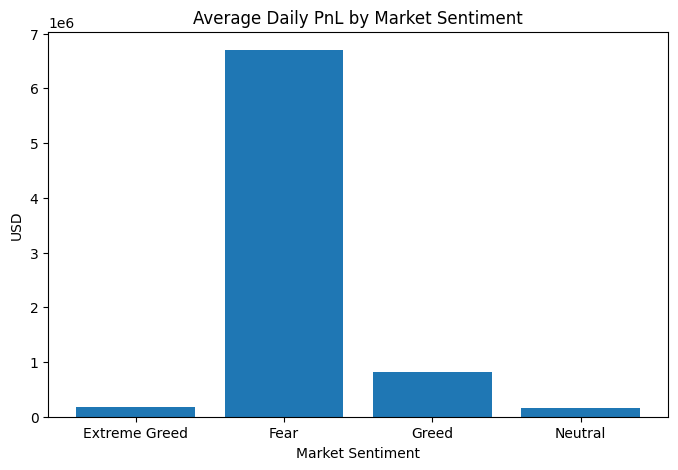

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(summary['value_classification'], summary['avg_daily_pnl'])
plt.title("Average Daily PnL by Market Sentiment")
plt.ylabel("USD")
plt.xlabel("Market Sentiment")
plt.show()



In [37]:
merged.groupby('value_classification')['volume_usd'].mean()


value_classification
Extreme Greed    3.940677e+07
Fear             7.041585e+08
Greed            1.064447e+08
Neutral          2.184323e+07
Name: volume_usd, dtype: float64

In [38]:
merged.groupby('value_classification')['total_pnl'].mean()


value_classification
Extreme Greed    1.769655e+05
Fear             6.699925e+06
Greed            8.153315e+05
Neutral          1.587424e+05
Name: total_pnl, dtype: float64

In [39]:
merged.groupby('value_classification')['win'].mean()


value_classification
Extreme Greed    1.00
Fear             1.00
Greed            0.75
Neutral          1.00
Name: win, dtype: float64